# Multiclass Semantic Segmentation: CityScape

## 1. Imports Libs and set the agnostic device


In [1]:
!pip install torchinfo
!pip install torchmetrics

In [2]:
import os
import zipfile
import glob
import random

import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import torch.nn.functional as F
from torchinfo import summary
from torchmetrics import JaccardIndex 

import torchvision
from torchvision import transforms
from PIL import Image

import matplotlib.pyplot as plt

from sklearn.utils import class_weight
import numpy as np


In [3]:
iou = JaccardIndex(task='multiclass',num_classes=30)
iou(F.softmax(torch.rand([32, 30, 244, 244]), dim=1), torch.rand([32, 1, 244, 244]).squeeze(dim=1))

tensor(0.0011)

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## 2. Get and preprocessing the Dataset

To get the data we need to login into Cityscapes site, once you have create your acount your can run the next cells to login into cityscapes and get the selected dataset, they have a lot of datasets, for this experiment we'll use the dataset describe below:

>Images

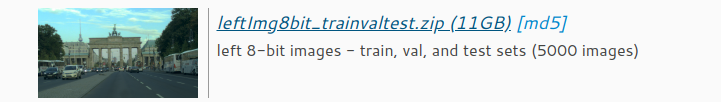

>Annotations

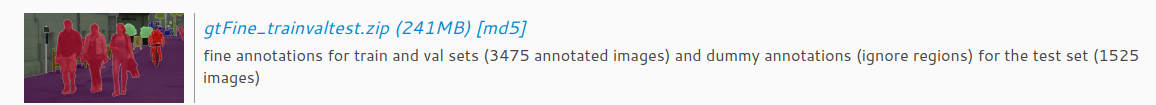

> Note: they also have an API that you can install using pip, if you want to dive deeper into this, the document is on GitHub: [Citysacepes Scripts](https://github.com/mcordts/cityscapesScripts)

In [5]:
# Login into cityscapes site and keep the cookies
username = ''
password = ''
command = f"wget --keep-session-cookies --save-cookies=cookies.txt --post-data 'username={username}&password={password}&submit=Login' https://www.cityscapes-dataset.com/login/"
!{command}

--2024-04-02 00:53:34--  https://www.cityscapes-dataset.com/login/
Resolving www.cityscapes-dataset.com (www.cityscapes-dataset.com)... 139.19.217.8
Connecting to www.cityscapes-dataset.com (www.cityscapes-dataset.com)|139.19.217.8|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.cityscapes-dataset.com/downloads/ [following]
--2024-04-02 00:53:36--  https://www.cityscapes-dataset.com/downloads/
Reusing existing connection to www.cityscapes-dataset.com:443.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: 'index.html.2'

index.html.2            [   <=>              ]  57.34K   112KB/s    in 0.5s    

2024-04-02 00:53:36 (112 KB/s) - 'index.html.2' saved [58715]



In [6]:
# Using the cookies to keep the session and donwload the data
# !wget --load-cookies cookies.txt --content-disposition https://www.cityscapes-dataset.com/file-handling/?packageID=3

In [7]:
# Download the annotations
!wget --load-cookies cookies.txt --content-disposition https://www.cityscapes-dataset.com/file-handling/?packageID=1

--2024-04-02 00:53:37--  https://www.cityscapes-dataset.com/file-handling/?packageID=1
Resolving www.cityscapes-dataset.com (www.cityscapes-dataset.com)... 139.19.217.8
Connecting to www.cityscapes-dataset.com (www.cityscapes-dataset.com)|139.19.217.8|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252567705 (241M) [application/octet-stream]
Saving to: 'gtFine_trainvaltest.zip.2'

gtFine_trainvaltest 100%[===================>] 240.87M  13.0MB/s    in 21s     

2024-04-02 00:53:59 (11.7 MB/s) - 'gtFine_trainvaltest.zip.2' saved [252567705/252567705]



In [8]:
# Delete cookies file for security
!rm /content/cookies.txt

rm: cannot remove '/content/cookies.txt': No such file or directory


In [9]:
# with zipfile.ZipFile('/kaggle/working/leftImg8bit_trainvaltest.zip') as file:
#   file.extractall('./')

In [10]:
# Unzip the data
with zipfile.ZipFile('/kaggle/working/gtFine_trainvaltest.zip') as file:
  file.extractall('./')

In [11]:
base_path = '/kaggle/input/small-cityscape/leftImg8bit_trainvaltest'
train_path = f'{base_path}/train'
val_path = f'{base_path}/val'
# test_path = f'{base_path}/test'

base_path = '/kaggle/working/'
train_anns = f'{base_path}/gtFine/train'
val_anns = f'{base_path}/gtFine/val'
# test_anns = f'{base_path}/gtFine/test'

files = glob.glob('*.txt')
print(f'Number of train samples: {len(glob.glob(train_path + "/*/*.png"))}')
print(f'Number of validation samples: {len(glob.glob(val_path + "/*/*.png"))}')
# print(f'Number of test samples: {len(glob.glob(test_path + "/*/*.png"))}')

Number of train samples: 270
Number of validation samples: 267


### 2.1 Create Dataset Class

In [12]:
class CityscapesDataset(Dataset):
  __default_transform = transforms.Compose([transforms.Resize((512, 512)), transforms.ToTensor()])
  __default_label_transform = transforms.Compose([transforms.Resize((512, 512)), transforms.PILToTensor()])

  def __init__(self,
               data_path: str,
               anns_path: str,
               gray_scale_masks=False,
               transformer: transforms.Compose=__default_transform,
               label_transformer: transforms.Compose=__default_label_transform,
               train: bool=True):

    super().__init__()
    self.data_path = data_path
    self.anns_path = anns_path
    self.transformer = transformer
    self.label_transformer = label_transformer
    self.images = glob.glob(self.data_path + "/*/*.png")
    self.anns = glob.glob(self.anns_path + "/*/*_gtFine_labelIds.png")
    if train:
        self.class_weights = self.__get_class_weights()

  def __len__(self):
    return len(self.images)


  def __getitem__(self, index) -> tuple:
    # Get the path os the mask
    image_name = self.images[index].split('/')[-1]
    mask_path = list(filter(lambda x: x.split('/')[-1].split('gtFine_labelIds')[0] in image_name, self.anns))[0]

    # Open and transform the selexted image
    image = Image.open(self.images[index])
    image = self.transformer(image)

    # Do the same to the mask
    mask = Image.open(mask_path)
    mask = self.label_transformer(mask)
    return image, mask


  def __get_class_weights(self):
        labels = np.array([self.transformer(Image.open(mask_path)).numpy() for mask_path in self.anns[120:]]).flatten()
        return class_weight.compute_class_weight(class_weight='balanced',
                                                  classes=np.unique(labels),
                                                  y=labels)


  def show_random_samples(self, number: int=3, only_images=False, only_masks=False) -> None:
    samples = random.choices(range(0, len(self.images)), k=number)
    for i, sample in enumerate(samples):
      plt.figure(figsize=(15, 15))

      img, mask = self.__getitem__(sample)
      img = img.permute(1, 2, 0)
      mask = mask.permute(1, 2, 0)

      if not only_masks:
        rows = 1
        if not only_images:
          rows = 2

        plt.subplot(1, rows, 1)
        plt.imshow(img)
        plt.axis(False)

      if not only_images:
        row_id = 2
        if only_masks:
          row_id = 1

        plt.subplot(1, row_id, row_id)
        plt.imshow(mask)
        plt.axis(False)



In [13]:
train_dataset = CityscapesDataset(data_path=train_path,
                                  anns_path=train_anns)

val_dataset = CityscapesDataset(data_path=val_path,
                                anns_path=val_anns,
                                train=False)

len(train_dataset), len(val_dataset)

(270, 267)

In [14]:
print(train_dataset.class_weights)

[3.10112224e+02 6.68516196e-01 2.05961686e+00 2.24982399e+00
 2.32636000e+00 6.59844690e+00 2.11677076e+00 9.07604751e-02
 5.54318925e-01 3.62850118e+00 9.01454985e+00 1.51463946e-01
 3.35413595e+00 2.91348212e+00 1.24843599e+01 6.01725595e+00
 9.56278187e+00 3.77546721e+00 1.18971079e+01 8.30473054e+00
 4.12918694e+00 2.16560739e-01 2.52749874e+00 8.44754254e-01
 2.92826344e+00 1.61094842e+01 4.93793843e-01 1.18786116e+01
 1.39377295e+01 5.78095823e+01 9.43765473e+01 1.75245850e+01
 3.42195658e+01 9.37454815e+00]


In [15]:
train_dataset[0][1]

tensor([[[3, 3, 3,  ..., 3, 3, 3],
         [3, 3, 3,  ..., 3, 3, 3],
         [3, 3, 3,  ..., 3, 3, 3],
         ...,
         [3, 3, 3,  ..., 3, 3, 3],
         [3, 3, 3,  ..., 3, 3, 3],
         [3, 3, 3,  ..., 3, 3, 3]]], dtype=torch.uint8)

In [16]:
train_dataset[0][0].shape, train_dataset[0]

(torch.Size([3, 512, 512]),
 (tensor([[[0.2863, 0.4706, 0.6000,  ..., 0.1922, 0.6510, 0.4941],
           [0.2000, 0.3451, 0.4863,  ..., 0.2039, 0.6314, 0.4784],
           [0.4549, 0.4196, 0.3922,  ..., 0.2078, 0.6118, 0.4627],
           ...,
           [0.2392, 0.2392, 0.2471,  ..., 0.2353, 0.2353, 0.2353],
           [0.2431, 0.2392, 0.2471,  ..., 0.2353, 0.2314, 0.2353],
           [0.2431, 0.2392, 0.2471,  ..., 0.2353, 0.2314, 0.2314]],
  
          [[0.4039, 0.5765, 0.6980,  ..., 0.2902, 0.6275, 0.1961],
           [0.2941, 0.4510, 0.5843,  ..., 0.2941, 0.6118, 0.2000],
           [0.5451, 0.5098, 0.4902,  ..., 0.3020, 0.5882, 0.2118],
           ...,
           [0.2902, 0.2863, 0.2863,  ..., 0.2784, 0.2784, 0.2824],
           [0.2902, 0.2863, 0.2863,  ..., 0.2863, 0.2784, 0.2784],
           [0.2902, 0.2863, 0.2863,  ..., 0.2824, 0.2784, 0.2784]],
  
          [[0.2078, 0.3961, 0.6392,  ..., 0.2745, 0.6039, 0.1451],
           [0.0353, 0.1882, 0.4824,  ..., 0.2745, 0.5843, 0.1

In [17]:
train_dataset[0][1].shape

torch.Size([1, 512, 512])

### 2.2 View random samples with its mask



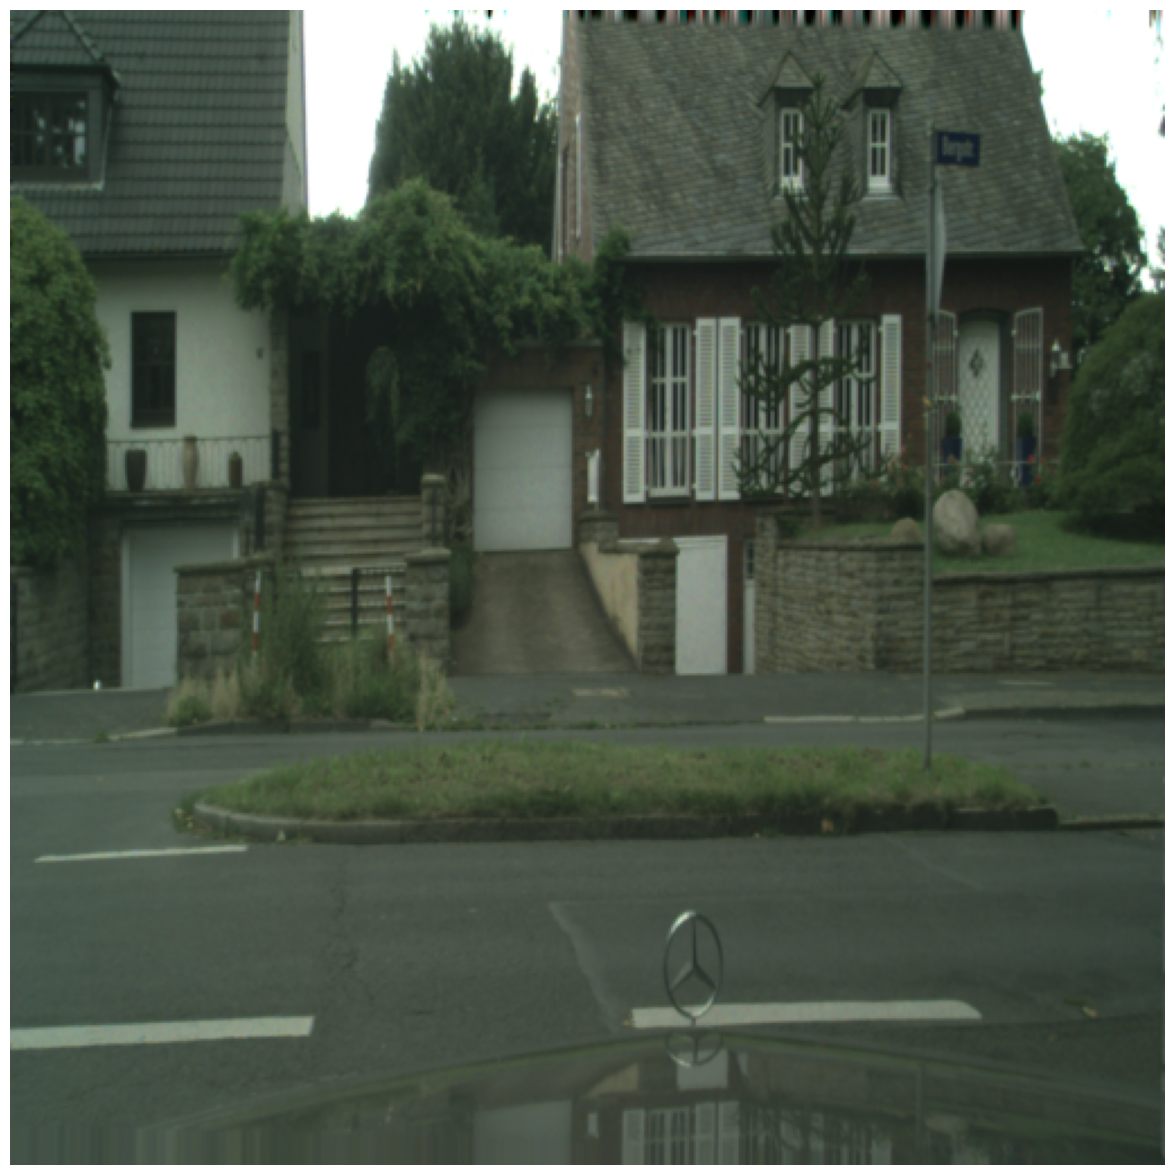

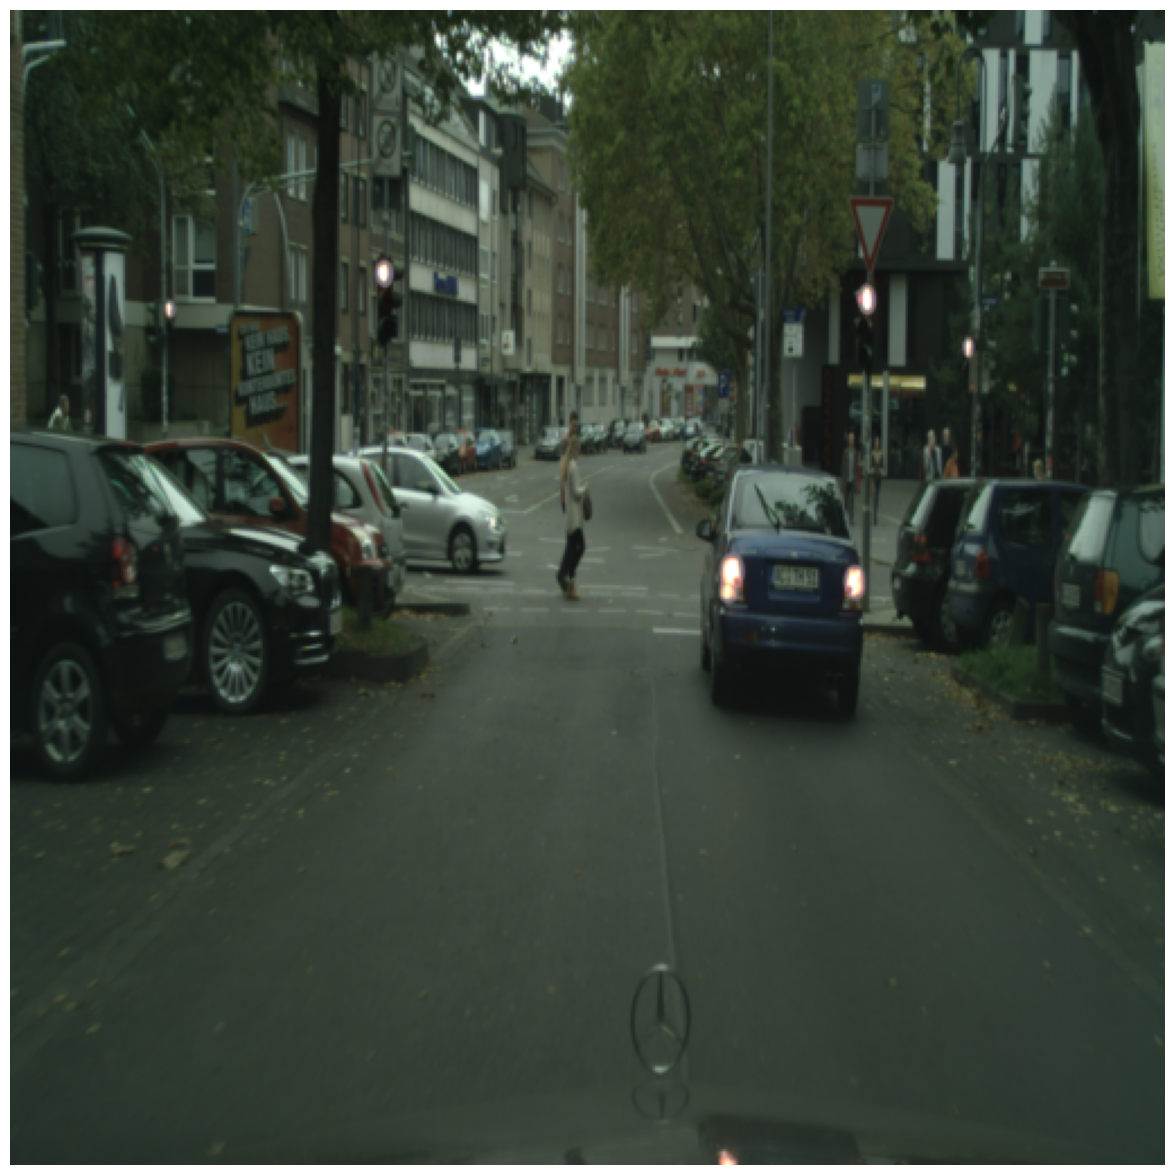

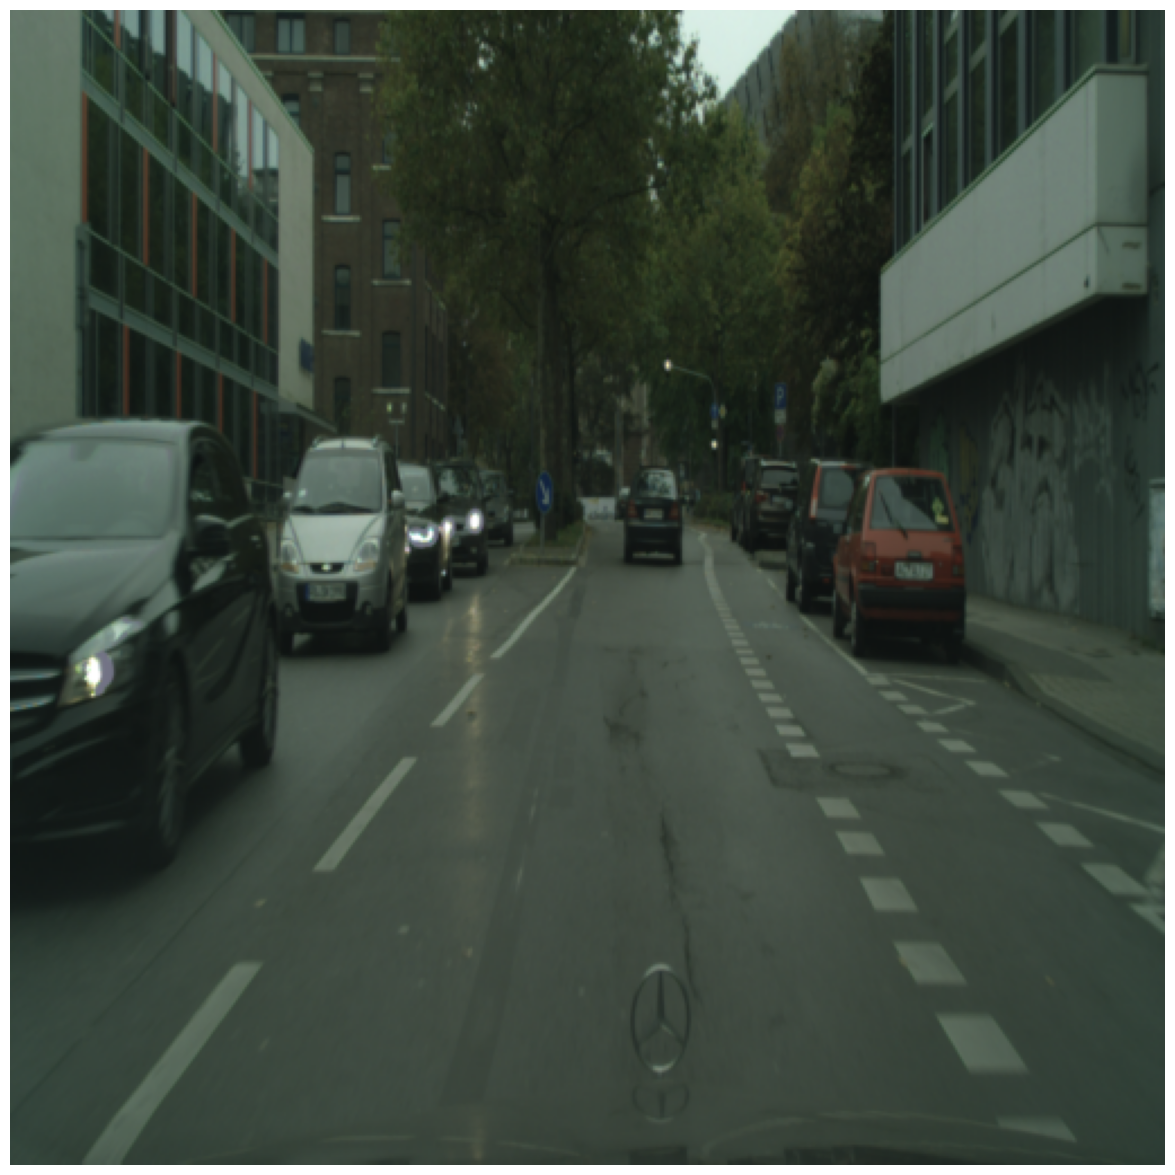

In [18]:
train_dataset.show_random_samples(only_images=True)

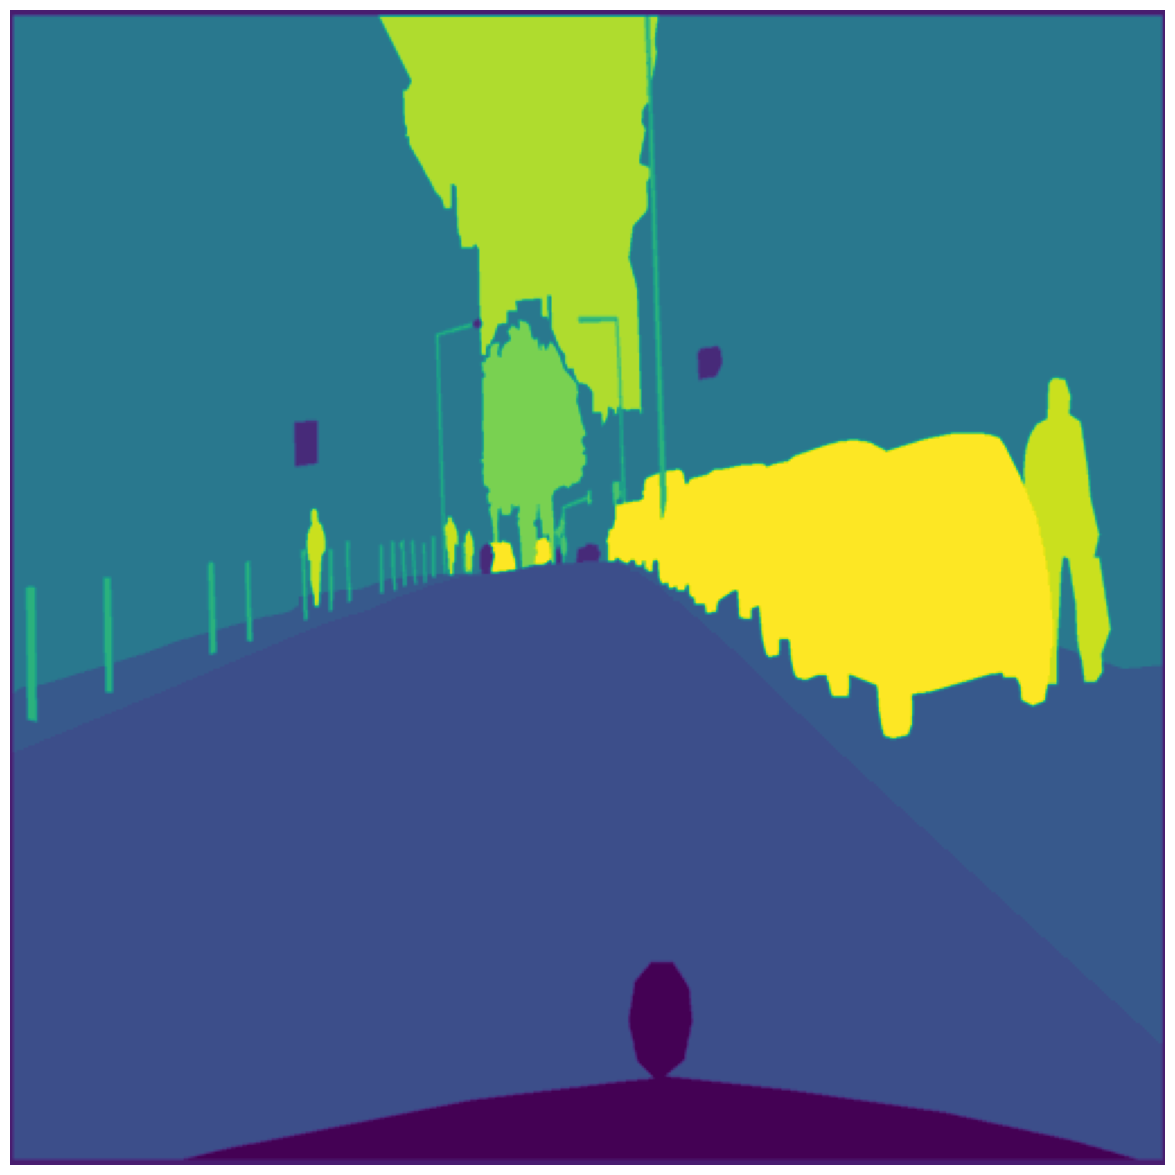

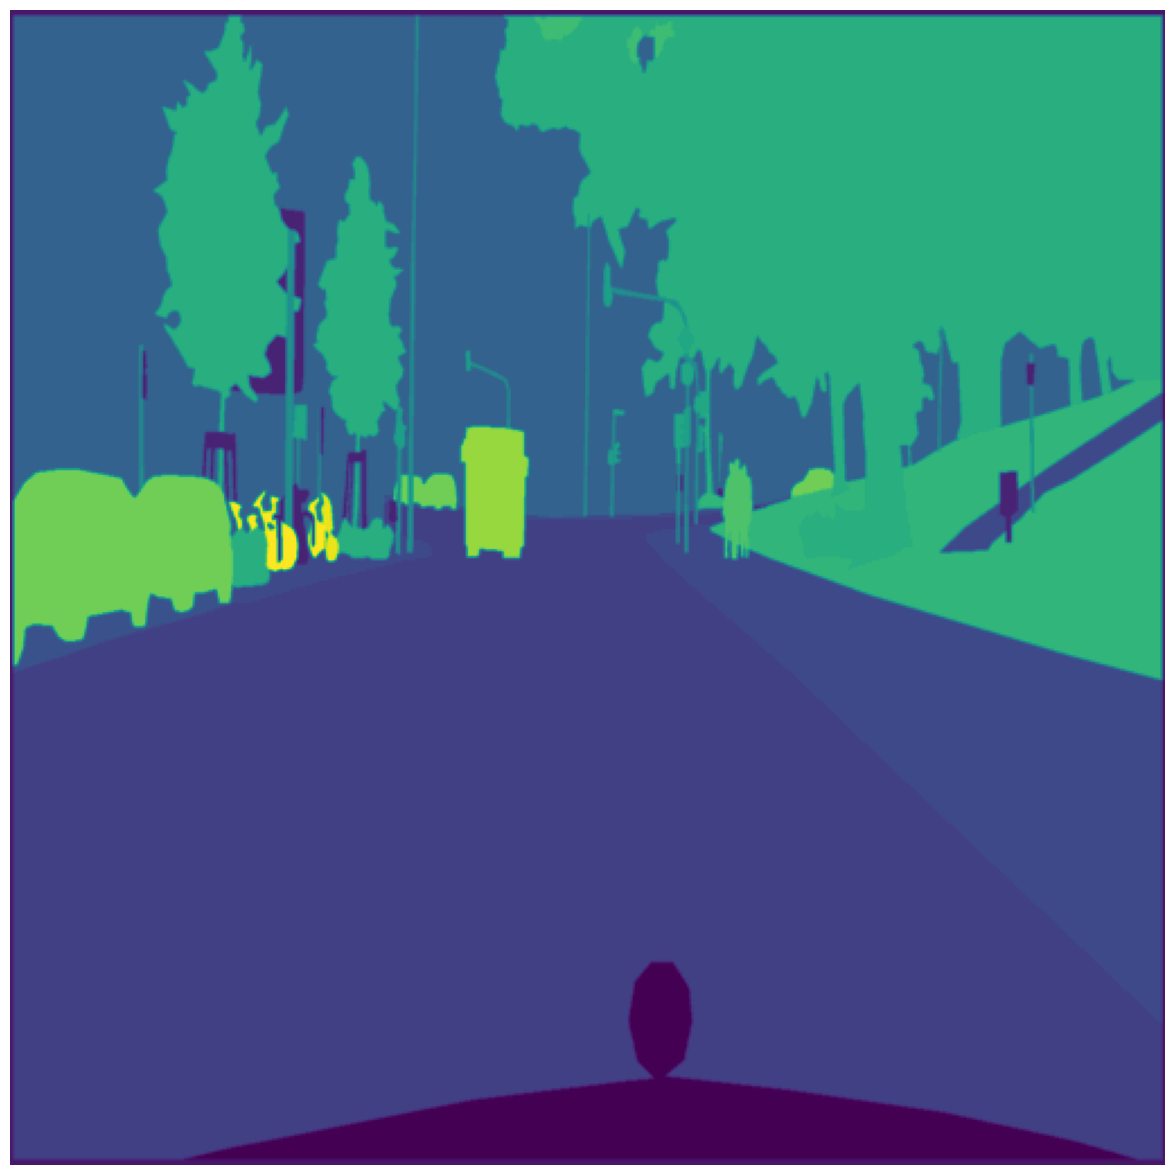

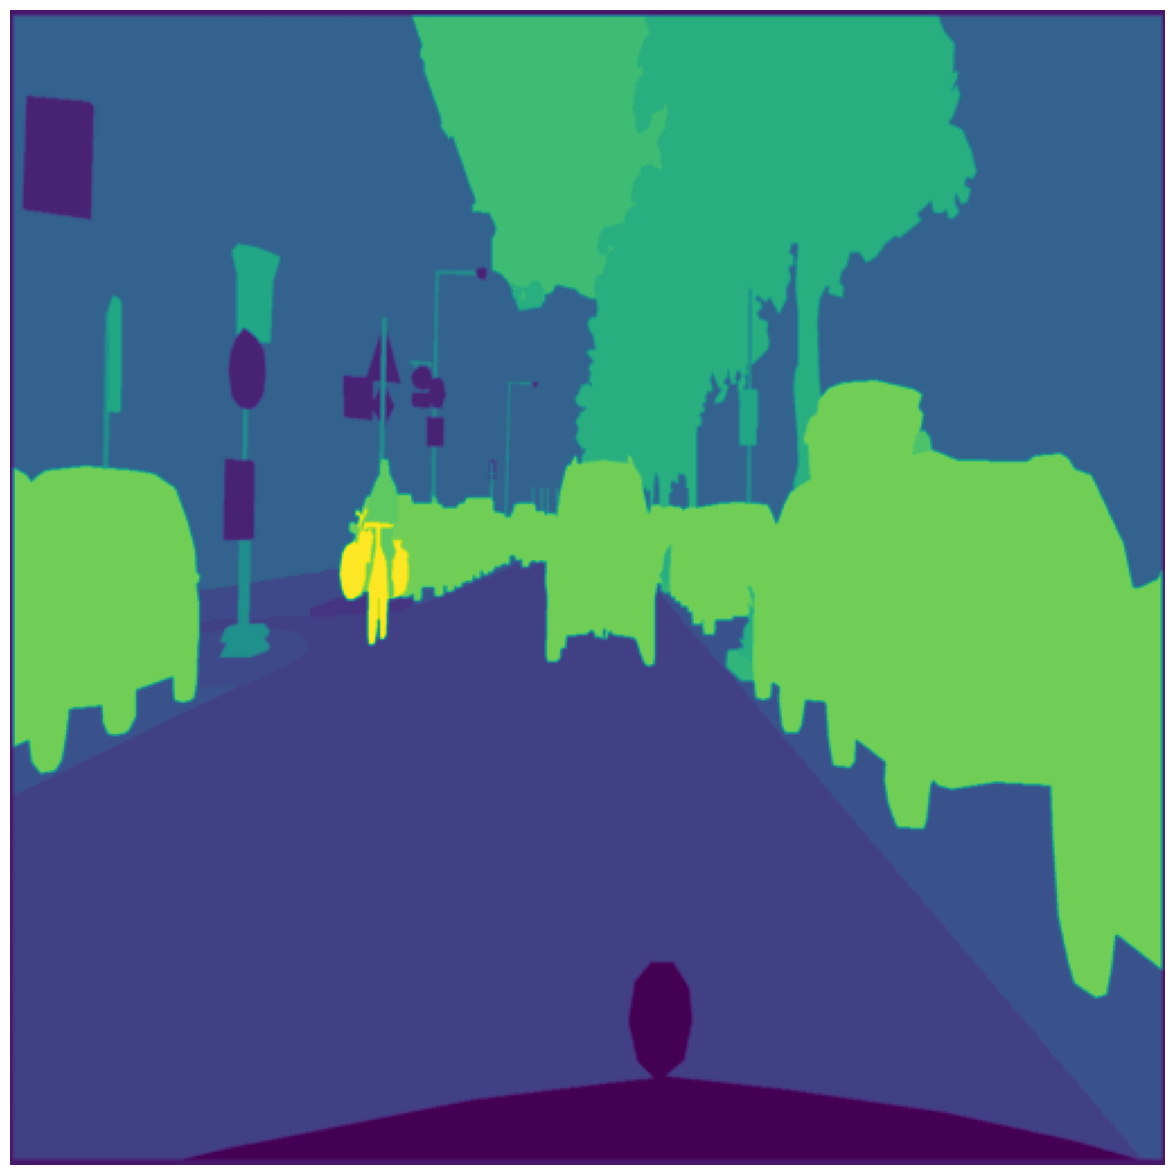

In [19]:
train_dataset.show_random_samples(only_masks=True)

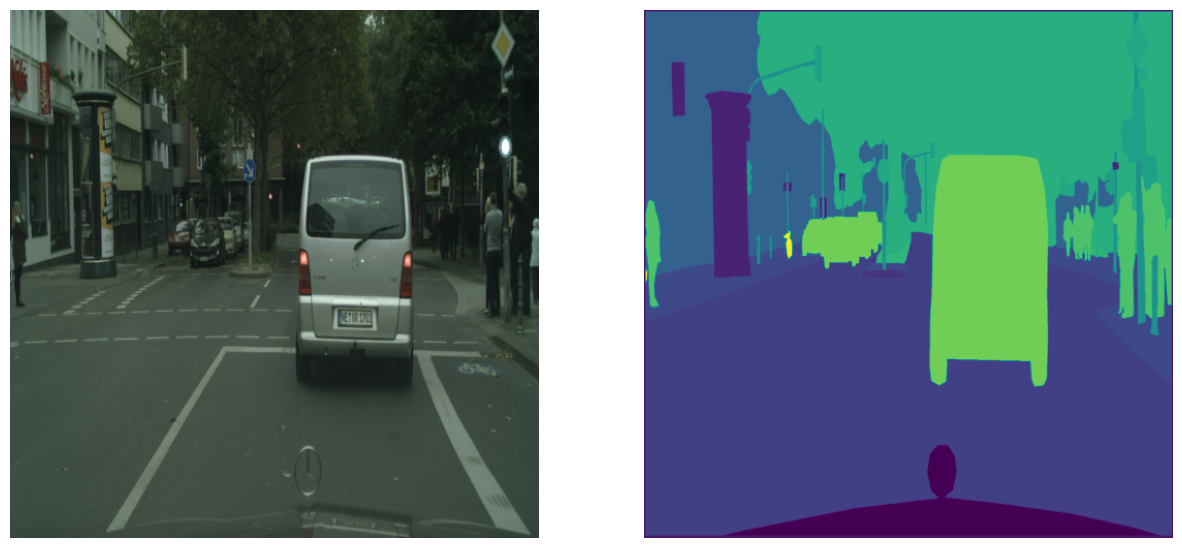

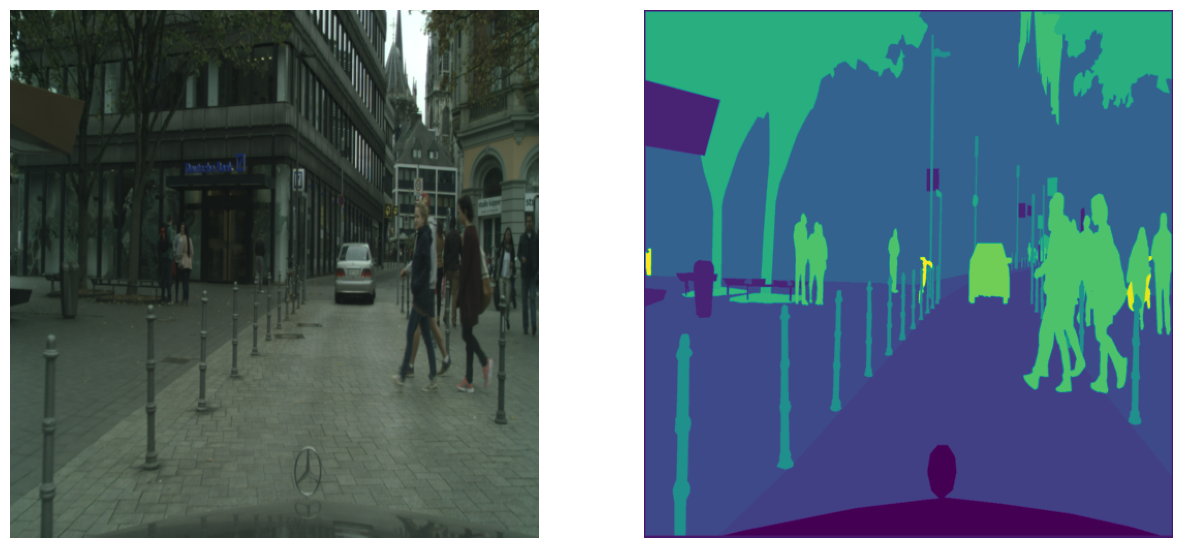

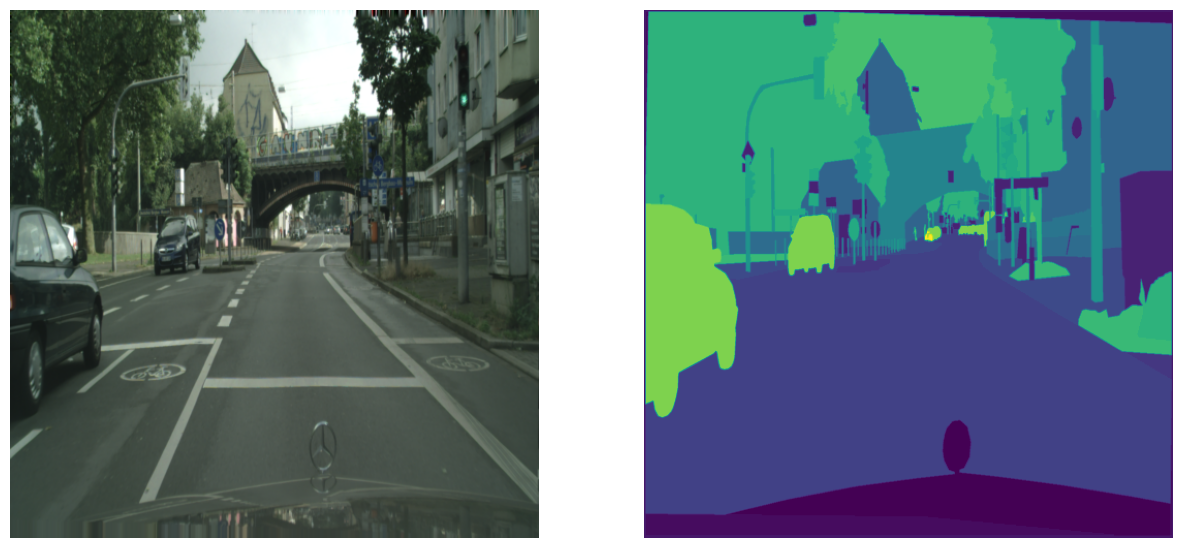

In [20]:
train_dataset.show_random_samples()

### 2.3 Create Dataloaders

In [23]:
BATCH_SIZE = 8

train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

val_dataloader = DataLoader(dataset=val_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=False)

## 3. Create the Unet model

In [24]:
class ConvBlock(nn.Module):
  def __init__(self, in_channels: int=3, out_channels:int=64, kernel_size=(3, 3)):
    super().__init__()
    self.conv_block = nn.Sequential(
      nn.Conv2d(in_channels=in_channels,
                  out_channels=out_channels,
                  kernel_size=kernel_size,
                  padding=1),

      nn.BatchNorm2d(out_channels),
      nn.ReLU(),

      nn.Conv2d(in_channels=out_channels,
                out_channels=out_channels,
                kernel_size=kernel_size,
                padding=1),
      nn.BatchNorm2d(out_channels),
      nn.ReLU()
    )

  def forward(self, x):
    return self.conv_block(x)


class EncoderMiniBlock(nn.Module):
  def __init__(self,  in_channels: int=3, out_channels:int=64, kernel_size=(3, 3)) -> None:
    super().__init__()
    self.conv_block = ConvBlock(in_channels=in_channels,
                              out_channels=out_channels,
                              kernel_size=kernel_size)

    self.max_pool = nn.MaxPool2d(kernel_size=(2,2),
                                    stride=2)

  def forward(self, x):

    # Skip connections
    skip = self.conv_block(x)

    x = self.max_pool(skip)
    # print(x.shape)
    return skip, x


class DecoderMiniBlock(nn.Module):
  def __init__(self,  in_channels: int=3, out_channels:int=64, kernel_size=(3, 3)) -> None:
    super().__init__()
    self.up_conv = nn.ConvTranspose2d(in_channels=in_channels,
                                      out_channels=out_channels,
                                      kernel_size=(2, 2),
                                      stride=2)

    self.conv_block = ConvBlock(in_channels=in_channels,
                              out_channels=out_channels,
                              kernel_size=kernel_size)

  def forward(self, x, skip):
    # Upsample
    x = self.up_conv(x)

    # Concate filters
    x = torch.concat([x, skip], dim=1)

    # Double conv
    x = self.conv_block(x)
    # print(x.shape)

    return x

class Unet(nn.Module):
  def __init__(self, in_channels, n_classes):
    super().__init__()
    self.n_classes = n_classes
    self.filters = [in_channels, 64, 128, 256, 512]

    # Create the miniblocks for encoder
    self.encoder_block = nn.ModuleList()
    for number_filters in range(len(self.filters)-1):
      self.encoder_block.append(EncoderMiniBlock(in_channels=self.filters[number_filters],
                                                 out_channels=self.filters[number_filters+1]))

    # Intermedialty double convolution
    self.conv_block = ConvBlock(in_channels=self.filters[-1],
                              out_channels=self.filters[-1]*2,
                              kernel_size=(3, 3))

    # Do the same to Decoder block
    self.decoder_block = nn.ModuleList()
    for number_filters in range(len(self.filters)-1, 0, -1):
      self.decoder_block.append(DecoderMiniBlock(in_channels=self.filters[number_filters]*2,
                                                 out_channels=self.filters[number_filters]))

    # Last convolution
    self.last_conv = nn.Conv2d(in_channels=self.filters[1],
                               out_channels=self.n_classes,
                               kernel_size=1)

  def forward(self, x):
    skip_features = []
    for miniblock in self.encoder_block:
      skip, x = miniblock(x)
      skip_features.append(skip)


    x = self.conv_block(x)
    # print(x.shape)

    for miniblock, skip_features in zip(self.decoder_block, reversed(skip_features)):
      x = miniblock(x, skip_features)

    x = self.last_conv(x)

    return x

In [25]:
model_1 = Unet(in_channels=3, n_classes=34)
model_1.to(device)

Unet(
  (encoder_block): ModuleList(
    (0): EncoderMiniBlock(
      (conv_block): ConvBlock(
        (conv_block): Sequential(
          (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (5): ReLU()
        )
      )
      (max_pool): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): EncoderMiniBlock(
      (conv_block): ConvBlock(
        (conv_block): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1,

In [26]:
summary(model_1, input_size=[1,3,512,512])

Layer (type:depth-idx)                        Output Shape              Param #
Unet                                          [1, 34, 512, 512]         --
├─ModuleList: 1-1                             --                        --
│    └─EncoderMiniBlock: 2-1                  [1, 64, 512, 512]         --
│    │    └─ConvBlock: 3-1                    [1, 64, 512, 512]         38,976
│    │    └─MaxPool2d: 3-2                    [1, 64, 256, 256]         --
│    └─EncoderMiniBlock: 2-2                  [1, 128, 256, 256]        --
│    │    └─ConvBlock: 3-3                    [1, 128, 256, 256]        221,952
│    │    └─MaxPool2d: 3-4                    [1, 128, 128, 128]        --
│    └─EncoderMiniBlock: 2-3                  [1, 256, 128, 128]        --
│    │    └─ConvBlock: 3-5                    [1, 256, 128, 128]        886,272
│    │    └─MaxPool2d: 3-6                    [1, 256, 64, 64]          --
│    └─EncoderMiniBlock: 2-4                  [1, 512, 64, 64]          --
│    │

## 4. Train model

In [27]:
def train_step(model: nn.Module,
               dataloader: DataLoader,
               loss_fn: nn.Module,
               optimizer: torch.optim.Optimizer,
               iou,
               device):

  total_loss = 0
  total_iou = 0
  model.train()
  model.to(device)
  # Loop through batchs
  for images, masks in dataloader:
    images, masks = images.to(device), masks.to(device)

    # 1. Forward pass
    logits = model(images)

    # 2. Calculate the loss
    loss = loss_fn(logits, masks.squeeze(1).long())
    total_loss += loss.item()
    
    # Calculate IoU
#     total_iou += iou(logits, masks.squeeze(dim=1)).item()
    total_iou += iou(F.softmax(logits, dim=1).argmax(dim=1), masks.squeeze(dim=1)).item()
    

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    # Free memory
    # images = None
    # masks = None

  total_loss /= len(dataloader)
  total_iou /= len(dataloader)
    
  return total_loss, total_iou

def val_step(model: nn.Module,
             dataloader: DataLoader,
             loss_fn: nn.Module,
             iou,
             device):

  total_loss = 0
  total_iou = 0
  with torch.inference_mode():
    model.eval()
    model.to(device)
    for images, masks in dataloader:
      images, masks = images.to(device), masks.to(device)

      logits = model(images)
      loss = loss_fn(logits, masks.squeeze(1).long())
      total_loss += loss.item()
        
#       total_iou += iou(logits, masks.squeeze(dim=1)).item()
      total_iou += iou(F.softmax(logits, dim=1).argmax(dim=1), masks.squeeze(dim=1)).item()


      # Free memory
      # images = None
      # masks = None

    total_loss /= len(dataloader)
    total_iou /= len(dataloader)

  return total_loss, total_iou


def train(model: nn.Module,
          epochs: int,
          train_dataloader: DataLoader,
          val_dataloader: DataLoader,
          loss_fn: nn.Module,
          optimizer: torch.optim.Optimizer,
          iou,
          device):

  model.to(device)

  history = {
      'train_loss': [],
      'val_loss': [],
      'train_iou': [],
      'val_iou': []
  }

  for epoch in range(epochs):
    train_loss, train_iou = train_step(model,
                            train_dataloader,
                            loss_fn,
                            optimizer,
                            iou,
                            device)

    val_loss, val_iou = val_step(model,
                          val_dataloader,
                          loss_fn,
                          iou,
                          device)

    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_iou'].append(train_iou)
    history['val_iou'].append(val_iou)

    print(f"Epoch: {epoch} | Train Loss: {train_loss}, | Validation Loss {val_loss} | Train IoU: {train_iou}, | Validation IoU {val_iou}")

  return history


In [28]:
torch.Tensor(train_dataset.class_weights).shape

torch.Size([34])

In [29]:
# Create Loss Function and Optimzier
loss_fn = nn.CrossEntropyLoss(weight=torch.Tensor(train_dataset.class_weights).to(device))
optimizer = torch.optim.Adam(model_1.parameters(), lr=1e-3)
iou = JaccardIndex(task='multiclass',num_classes=34).to(device)

In [30]:
history = train(model=model_1,
                epochs=10,
                train_dataloader=train_dataloader,
                val_dataloader=val_dataloader,
                loss_fn=loss_fn,
                optimizer=optimizer,
                iou=iou,
                device=device)

Epoch: 0 | Train Loss: 3.127724226783304, | Validation Loss 4.889988464467666 | Train IoU: 0.0642469810486278, | Validation IoU 0.011594889356809504
Epoch: 1 | Train Loss: 2.7113084091859707, | Validation Loss 3.6739342423046337 | Train IoU: 0.11622836703763288, | Validation IoU 0.07338873757159009
Epoch: 2 | Train Loss: 2.5690003563376034, | Validation Loss 3.362637295442469 | Train IoU: 0.13181526104316993, | Validation IoU 0.10378494924482178
Epoch: 3 | Train Loss: 2.434260045780855, | Validation Loss 3.274240430663614 | Train IoU: 0.14732997228994088, | Validation IoU 0.07595427630140501
Epoch: 4 | Train Loss: 2.3852254643159756, | Validation Loss 3.466479546883527 | Train IoU: 0.15085664566825419, | Validation IoU 0.11008456590421059
Epoch: 5 | Train Loss: 2.307612089549794, | Validation Loss 3.2502103833591236 | Train IoU: 0.1613437673624824, | Validation IoU 0.12314416270922213
Epoch: 6 | Train Loss: 2.293465761577382, | Validation Loss 3.197815951179056 | Train IoU: 0.160209381

In [31]:
# history

In [32]:
def plot_metric(metric_train, metric_val, metric_name):
    plt.figure(figsize=(7,7))
    plt.title(metric_name)
    plt.plot(range(len(metric_train)), metric_train, label='Train')   
    plt.plot(range(len(metric_val)), metric_val, label='Validation')
    plt.legend()

## 5. Plot Metrics

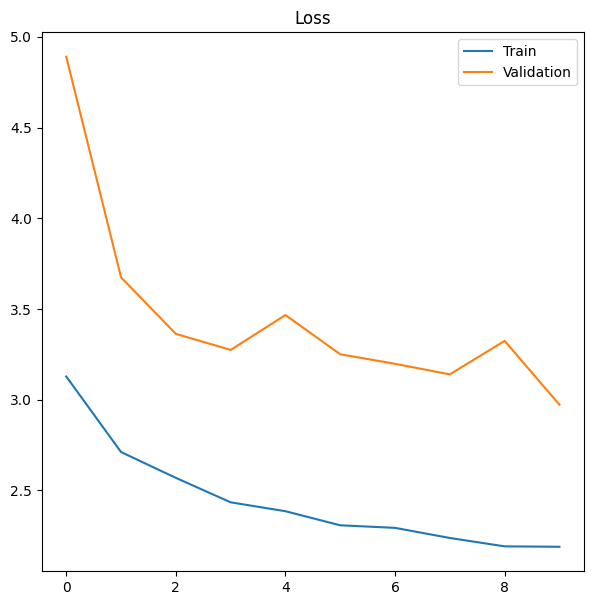

In [33]:
plot_metric(metric_train=history['train_loss'],
           metric_val=history['val_loss'],
           metric_name='Loss')

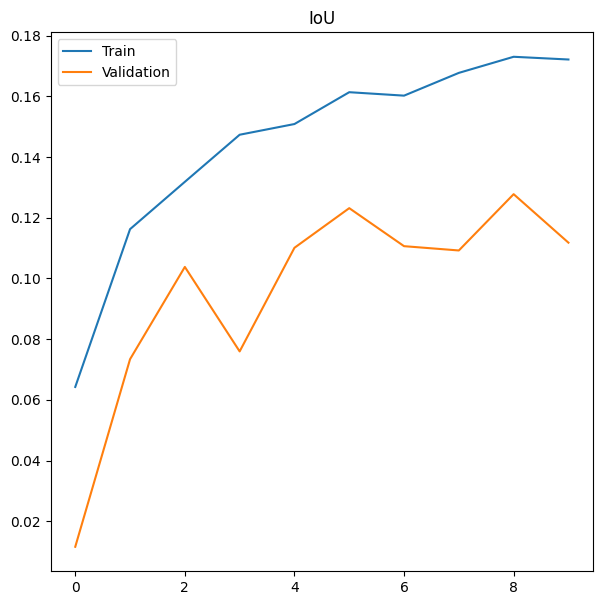

In [34]:
plot_metric(metric_train=history['train_iou'],
           metric_val=history['val_iou'],
           metric_name='IoU')

## 6. Test and save the model

In [35]:
torch.save(model_1, './city_scape_unet_model.pth')
load_model = torch.load('./city_scape_unet_model.pth')
# load_model

tensor([0.0095, 0.0010, 0.0064, 0.0051, 0.0457, 0.0191, 0.0082, 0.0025, 0.0022,
        0.0107, 0.0312, 0.0458, 0.0226, 0.0293, 0.0543, 0.0344, 0.0897, 0.1332,
        0.0868, 0.1288, 0.0473, 0.0359, 0.0108, 0.0046, 0.0308, 0.0180, 0.0108,
        0.0077, 0.0221, 0.0081, 0.0090, 0.0048, 0.0095, 0.0138])
tensor([2.5096e-03, 5.6791e-04, 1.4804e-03, 1.7582e-03, 2.0708e-02, 1.0381e-02,
        3.1654e-03, 8.2754e-04, 1.1729e-03, 9.3876e-03, 6.1250e-03, 3.4975e-02,
        2.6704e-02, 1.7023e-02, 1.0984e-02, 1.4583e-02, 1.6454e-02, 1.1038e-02,
        5.3959e-02, 7.4639e-02, 2.2258e-02, 5.9036e-01, 2.8578e-02, 1.2836e-03,
        7.0549e-03, 4.7207e-03, 3.1301e-03, 1.3337e-03, 1.3040e-02, 8.0371e-04,
        3.1401e-03, 8.4243e-04, 3.0034e-03, 2.0098e-03])
tensor([8.4909e-04, 1.0812e-04, 4.5033e-04, 8.4011e-04, 7.3069e-03, 4.7543e-03,
        2.1498e-03, 2.9566e-04, 8.8299e-04, 3.0519e-03, 2.7174e-03, 6.7627e-03,
        1.4091e-02, 1.3986e-02, 9.7732e-03, 9.5042e-03, 1.4163e-02, 7.9513e-03

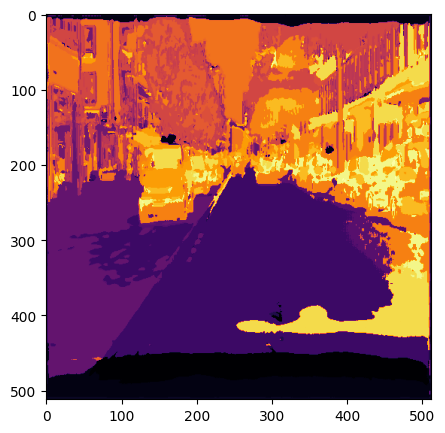

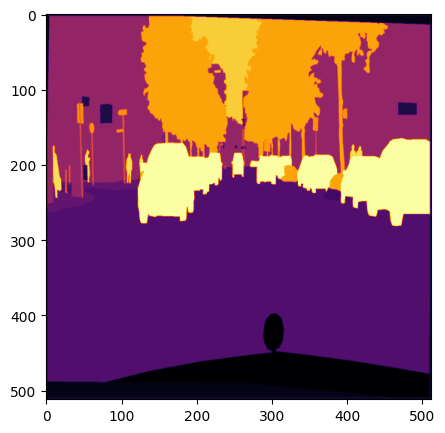

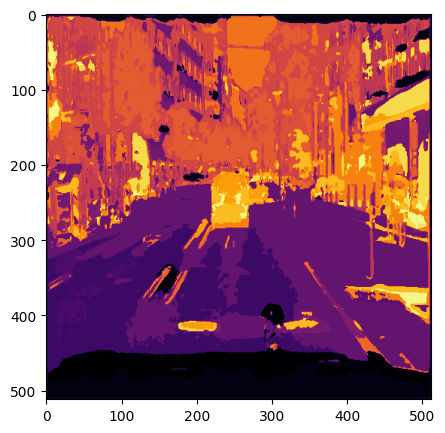

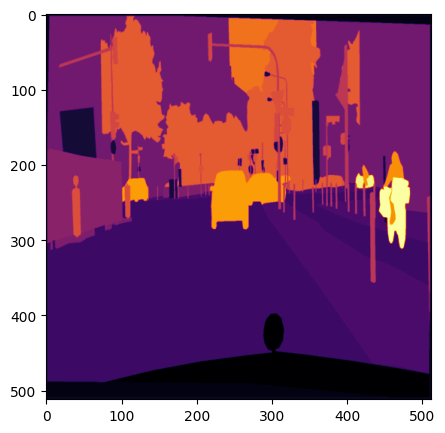

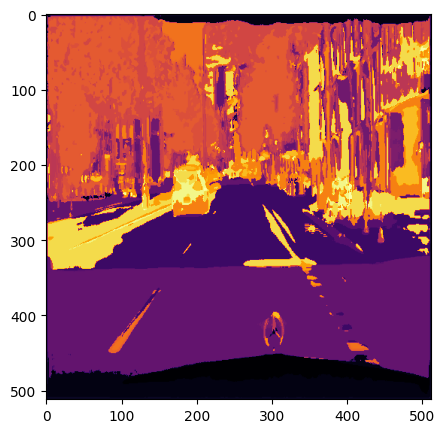

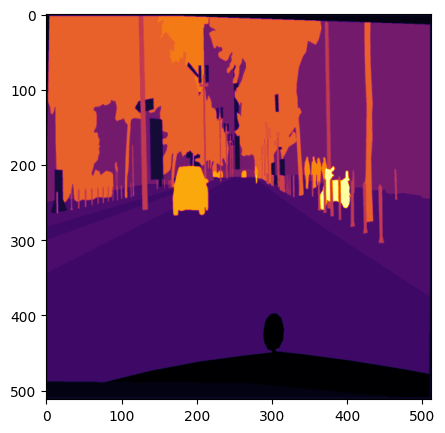

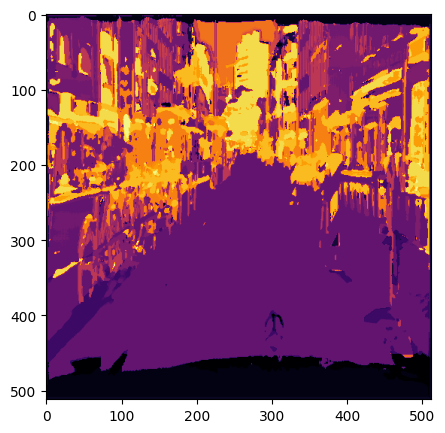

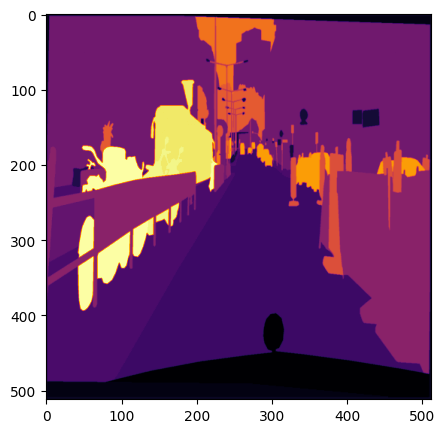

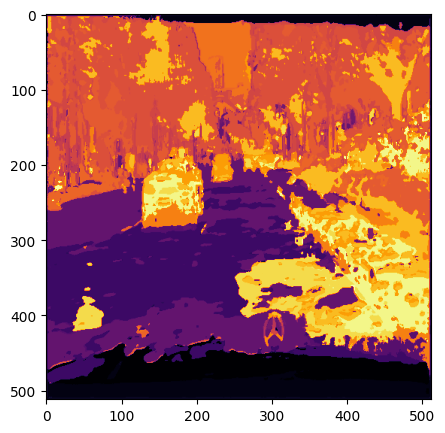

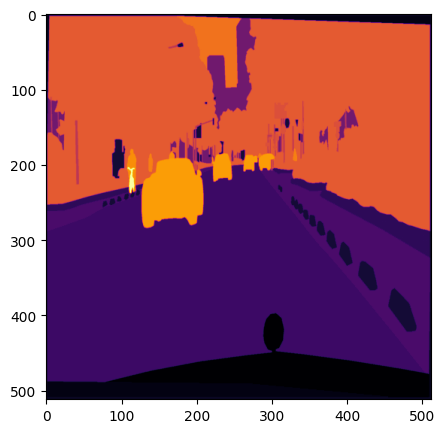

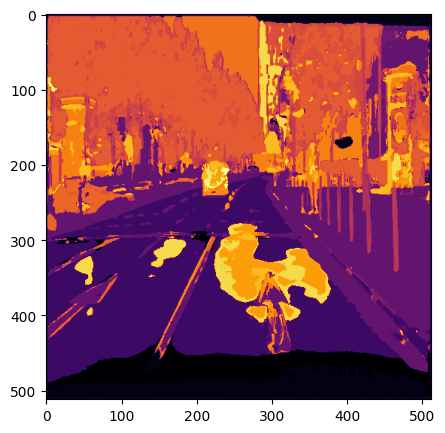

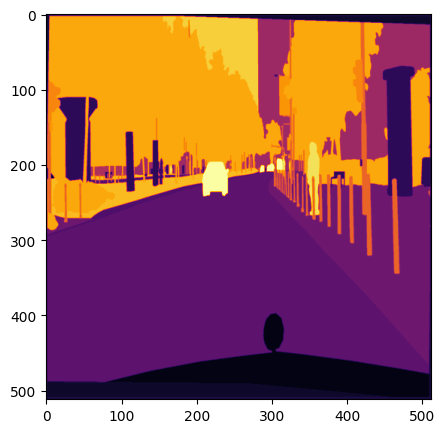

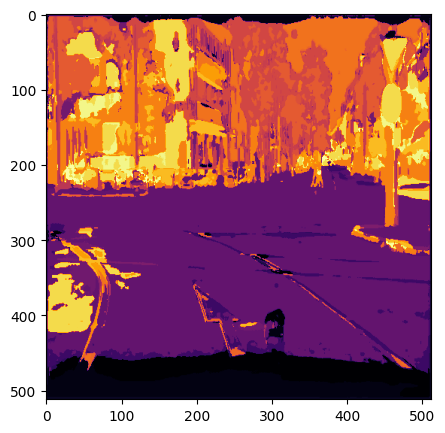

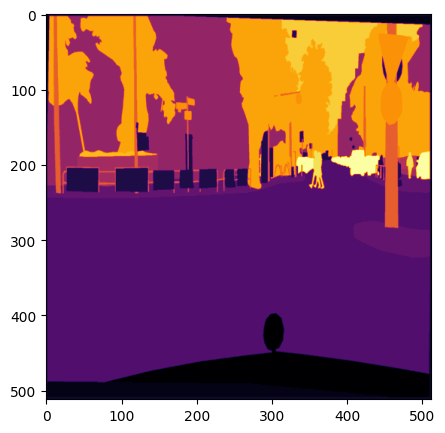

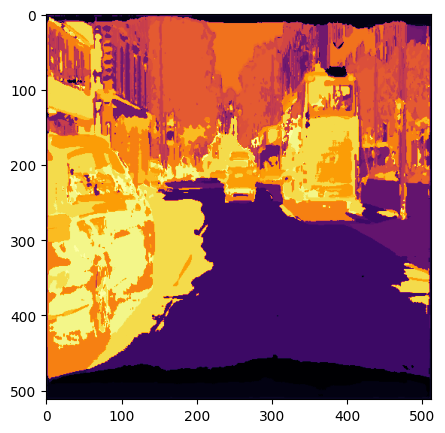

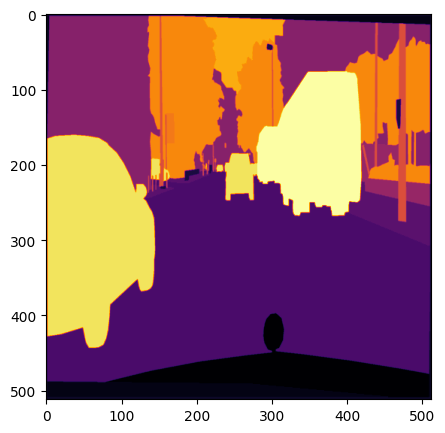

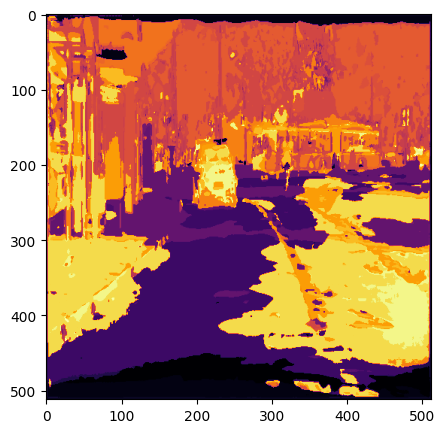

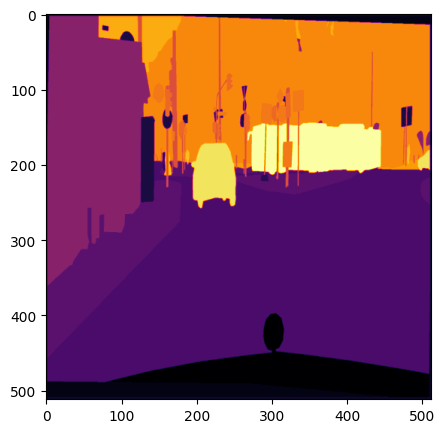

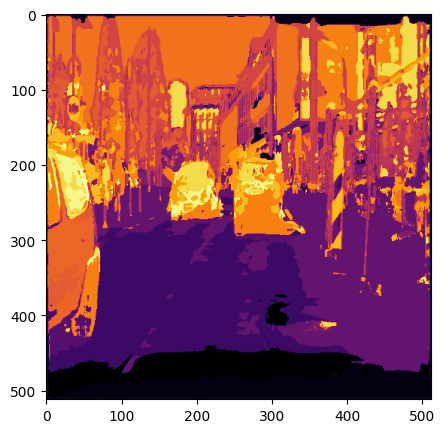

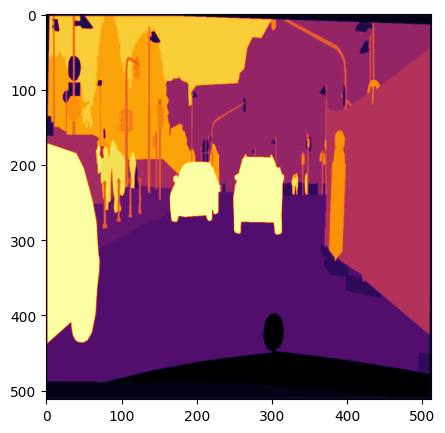

In [36]:
model_1.to('cpu')
model_1.eval()
with torch.inference_mode():
    for i in range(10):
        plt.figure(figsize=(5, 5))
        results = model_1(val_dataset[i][0].unsqueeze(dim=0))
#         print('before softmax: ', results.shape, torch.max(results))
        results = F.softmax(results, dim=1)
#         print('after softmax: ', results.shape, torch.max(results))
        print(results[0, :, 100, 100])

        results = torch.argmax(results[:, :, :, :], dim=1)
#         print('after argmax', results.shape, torch.max(results))
        plt.imshow(results.squeeze(0), cmap='inferno')  
        plt.figure(figsize=(5, 5))
    
        plt.imshow(val_dataset[i][1].squeeze(0), cmap='inferno')